<a href="https://colab.research.google.com/github/AyushKumarSD/Recyclable-and-Household-Waste-Classification/blob/main/VGG_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import gdown
from tempfile import NamedTemporaryFile
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
FILE_ID = '13hIBU7BbRlNNlP8_yRaPuOvsiMXIlNFc'
DOWNLOAD_URL = f'https://drive.google.com/uc?export=download&id={FILE_ID}'
KAGGLE_INPUT_PATH = '/kaggle/input'
KAGGLE_WORKING_PATH = '/kaggle/working'
KAGGLE_SYMLINK = 'kaggle'

# Unmount and setup directories
!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

# Setup symlinks
try:
    os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
    pass
try:
    os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
    pass

directory = 'recyclable-and-household-waste-classification'
destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
os.makedirs(destination_path, exist_ok=True)

try:
    print(f'Downloading {directory} from Google Drive')
    output_file = os.path.join(destination_path, 'archive.zip')
    gdown.download(DOWNLOAD_URL, output_file, quiet=False)

    # Extract the downloaded file
    if output_file.endswith('.zip'):
        with ZipFile(output_file, 'r') as zip_ref:
            zip_ref.extractall(destination_path)
    elif output_file.endswith('.tar.gz') or output_file.endswith('.tar'):
        with tarfile.open(output_file, 'r') as tar_ref:
            tar_ref.extractall(destination_path)
    else:
        raise ValueError(f"Unsupported file type: {output_file}")

    print(f'\nDownloaded and uncompressed: {directory}')
except Exception as e:
    print(f'Failed to load {DOWNLOAD_URL} to path {destination_path}: {e}')

print('Data source import complete.')


Downloading...
From (original): https://drive.google.com/uc?export=download&id=13hIBU7BbRlNNlP8_yRaPuOvsiMXIlNFc
From (redirected): https://drive.google.com/uc?export=download&id=13hIBU7BbRlNNlP8_yRaPuOvsiMXIlNFc&confirm=t&uuid=1ab1791f-d8af-48b5-a94d-54d4ba524101
To: /kaggle/input/recyclable-and-household-waste-classification/archive.zip
100%|██████████| 965M/965M [00:17<00:00, 55.8MB/s]



Downloaded and uncompressed: recyclable-and-household-waste-classification
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/recyclable-and-household-waste-classification/images/images/cardboard_packaging/real_world/Image_160.png
/kaggle/input/recyclable-and-household-waste-classification/images/images/cardboard_packaging/real_world/Image_148.png
/kaggle/input/recyclable-and-household-waste-classification/images/images/cardboard_packaging/real_world/Image_168.png
/kaggle/input/recyclable-and-household-waste-classification/images/images/cardboard_packaging/real_world/Image_42.png
/kaggle/input/recyclable-and-household-waste-classification/images/images/cardboard_packaging/real_world/Image_107.png
/kaggle/input/recyclable-and-household-waste-classification/images/images/cardboard_packaging/real_world/Image_121.png
/kaggle/input/recyclable-and-household-waste-classification/images/images/cardboard_packaging/real_world/Image_89.png
/kaggle/input/recyclable-and-household-waste-classification/images/images/cardboard_packaging/real_world/Image_44.png


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

In [4]:
# image directory
image_dir = "/kaggle/input/recyclable-and-household-waste-classification/images/images"

In [5]:
# data generator with data augmentation
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.2,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest'
                            )

In [6]:
# parameters
input_size = (256, 256)
batch_size = 32
epochs = 20

In [7]:
# training data generator
train_gen = datagen.flow_from_directory(
    image_dir,
    target_size = input_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training'
)

Found 12000 images belonging to 30 classes.


In [8]:
# validation data generator
valid_gen = datagen.flow_from_directory(
    image_dir,
    target_size = input_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation'
)

Found 3000 images belonging to 30 classes.


In [9]:
# Load the pre-trained VGG16 model without the fully connected layers
base_model = tf.keras.applications.VGG19(
    weights = 'imagenet',
    include_top = False,
    input_shape = (256, 256, 3)
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [10]:
# Freeze the pre-trained layers so they are not updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add classification layers on top of the pre-trained model
x = base_model.output
x = tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
flatten = tf.keras.layers.Flatten()(x)
predictions = tf.keras.layers.Dense(30, activation='softmax')(flatten)

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [11]:
# Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,512,314 (78.25 MB)

 Trainable params: 487,930 (1.86 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [12]:
model.compile(tf.keras.optimizers.Adam(learning_rate = 0.001),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [13]:
# History object contains the learning history e.g:- training and validation loss and accuracy
history = model.fit(train_gen,
                    steps_per_epoch = train_gen.samples // train_gen.batch_size,
                    epochs = epochs,
                    validation_data = valid_gen,
                    validation_steps = valid_gen.samples // valid_gen.batch_size
                   )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 317s 775ms/step - accuracy: 0.2583 - loss: 2.6330 - val_accuracy: 0.5299 - val_loss: 1.5510
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5417 - val_loss: 1.3841
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 324s 717ms/step - accuracy: 0.5299 - loss: 1.5518 - val_accuracy: 0.5780 - val_loss: 1.3656
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7083 - val_loss: 0.9262
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 320s 712ms/step - accuracy: 0.5756 - loss: 1.3580 - val_accuracy: 0.6146 - val_loss: 1.2470
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.2003
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 270s 711ms/step - accuracy: 0.6149 - loss: 1.2745 - val_accuracy: 0.6213 - val_loss: 1.1972
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7083 - val_loss: 0.9259
Epoch 9/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 270s 709ms/step - accuracy: 0

In [14]:
# Plot learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

Text(0.5, 1.0, 'Training and Validation Accuracy')

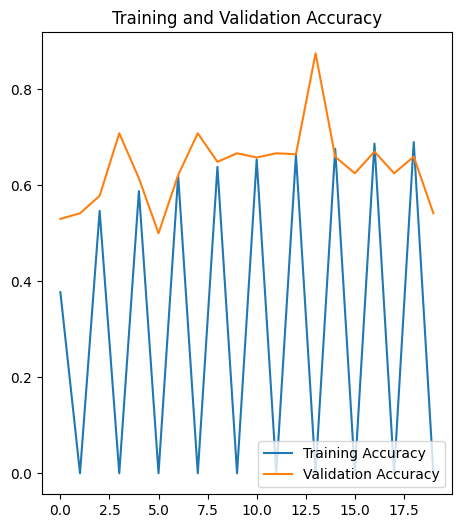

In [15]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

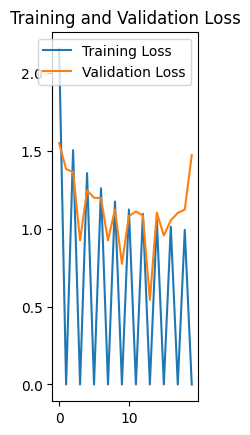

In [16]:
plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [17]:
# Evaluate model
valid_gen.reset()
Y_pred = model.predict(valid_gen, steps=valid_gen.samples // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = valid_gen.classes

94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 512ms/step


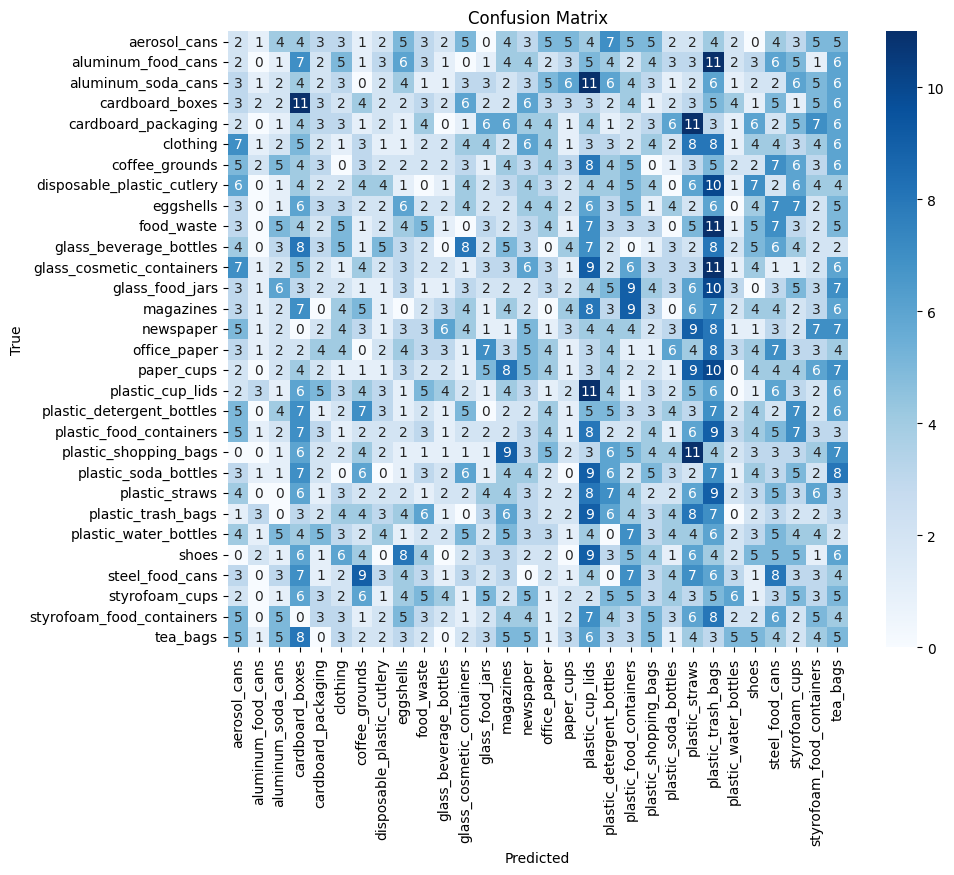

In [18]:
import seaborn as sns
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_gen.class_indices.keys(), yticklabels=valid_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=valid_gen.class_indices.keys()))

Classification Report
                            precision    recall  f1-score   support

              aerosol_cans       0.02      0.02      0.02       100
        aluminum_food_cans       0.00      0.00      0.00       100
        aluminum_soda_cans       0.03      0.02      0.02       100
           cardboard_boxes       0.07      0.11      0.09       100
       cardboard_packaging       0.04      0.03      0.04       100
                  clothing       0.01      0.01      0.01       100
            coffee_grounds       0.03      0.03      0.03       100
disposable_plastic_cutlery       0.06      0.04      0.05       100
                 eggshells       0.07      0.06      0.06       100
                food_waste       0.06      0.05      0.06       100
    glass_beverage_bottles       0.00      0.00      0.00       100
 glass_cosmetic_containers       0.01      0.01      0.01       100
           glass_food_jars       0.03      0.02      0.02       100
                 magazine

In [20]:
# ROC Curve and AUC
# Binarize the output for ROC and AUC calculations
y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=30)
y_pred_prob = model.predict(valid_gen, steps=valid_gen.samples // batch_size + 1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 511ms/step


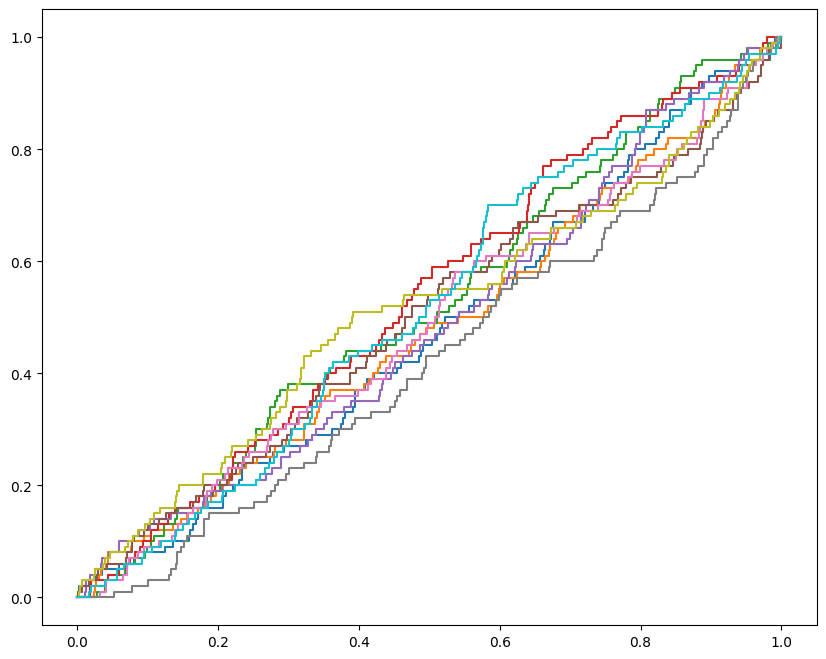

In [21]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

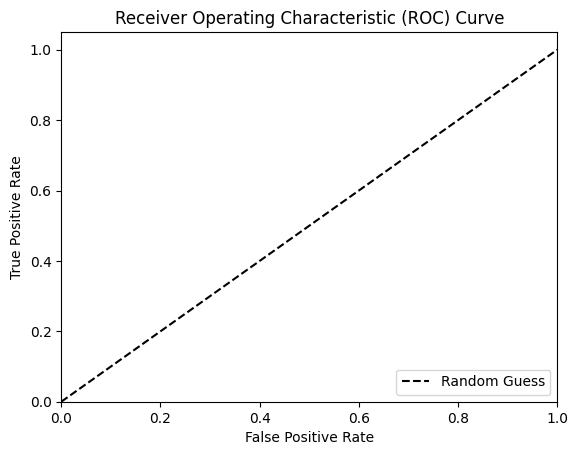

In [22]:
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [23]:
# Calculate and print the average AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 10
mean_auc = auc(all_fpr, mean_tpr)
print(f'Mean AUC: {mean_auc:.2f}')

Mean AUC: 0.49
